# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data
## Advanced Fraud Detection with Gaussian Mixture Models

This notebook demonstrates an advanced technique for handling severely imbalanced datasets in the context of fraud detection.  will use a Gaussian Mixture Model (GMM) to model the minority (fraud) class and generate high-quality synthetic samples to train a more robust classifier.

In [1]:
# Import comprehensive libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility and styling
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

print("Advanced libraries imported successfully!")
print("GMM-based synthetic sampling pipeline ready for implementation")

Advanced libraries imported successfully!
GMM-based synthetic sampling pipeline ready for implementation


# PART A: BASELINE MODEL AND DATA ANALYSIS
This section establishes a baseline performance using a standard Logistic Regression model trained on the original, imbalanced data. This will serve as benchmark for comparison.

## Task 1: Data Loading and Analysis

In [2]:
print("\n" + "="*80)
print("PART A: BASELINE MODEL AND DATA ANALYSIS")
print("="*80)


print("\n1. Data Loading and Comprehensive Analysis")
print("-" * 50)
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "creditcard.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mlg-ulb/creditcardfraud",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  #https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Comprehensive class distribution analysis
print("\n Class Distribution Analysis:")
print("-" * 40)

class_counts = df['Class'].value_counts().sort_index()
class_percentages = df['Class'].value_counts(normalize=True).sort_index() * 100

print(f"Normal transactions (Class 0): {class_counts[0]:,} ({class_percentages[0]:.3f}%)")
print(f"Fraudulent transactions (Class 1): {class_counts[1]:,} ({class_percentages[1]:.3f}%)")

# Calculate comprehensive imbalance metrics
imbalance_ratio = class_counts[0] / class_counts[1]
minority_percentage = class_percentages[1]

print(f"\n Imbalance Analysis:")
print(f"Imbalance Ratio (Normal:Fraud): {imbalance_ratio:.1f}:1")
print(f"Minority class percentage: {minority_percentage:.4f}%", "SEVERELY IMBALANCED")


PART A: BASELINE MODEL AND DATA ANALYSIS

1. Data Loading and Comprehensive Analysis
--------------------------------------------------
Using Colab cache for faster access to the 'creditcardfraud' dataset.

 Class Distribution Analysis:
----------------------------------------
Normal transactions (Class 0): 284,315 (99.827%)
Fraudulent transactions (Class 1): 492 (0.173%)

 Imbalance Analysis:
Imbalance Ratio (Normal:Fraud): 577.9:1
Minority class percentage: 0.1727% SEVERELY IMBALANCED


### Analysis of Class Imbalance

The dataset is loaded and analyzed for class distribution. The results confirm a **severe class imbalance**.

- **Fraudulent transactions (Class 1)** constitute only **0.173%** of the entire dataset.
- The **imbalance ratio** is approximately **577:9**, meaning there are 578 normal transactions for every single fraudulent one.

This extreme imbalance poses a significant challenge for model training. A naive model that always predicts 'Normal' would achieve over 99.8% accuracy but would be useless for fraud detection. Therefore, accuracy is a misleading metric for this problem, and   must focus on metrics that evaluate the model's ability to identify the rare minority class, such as Precision, Recall, and F1-score.

### Data Visualization

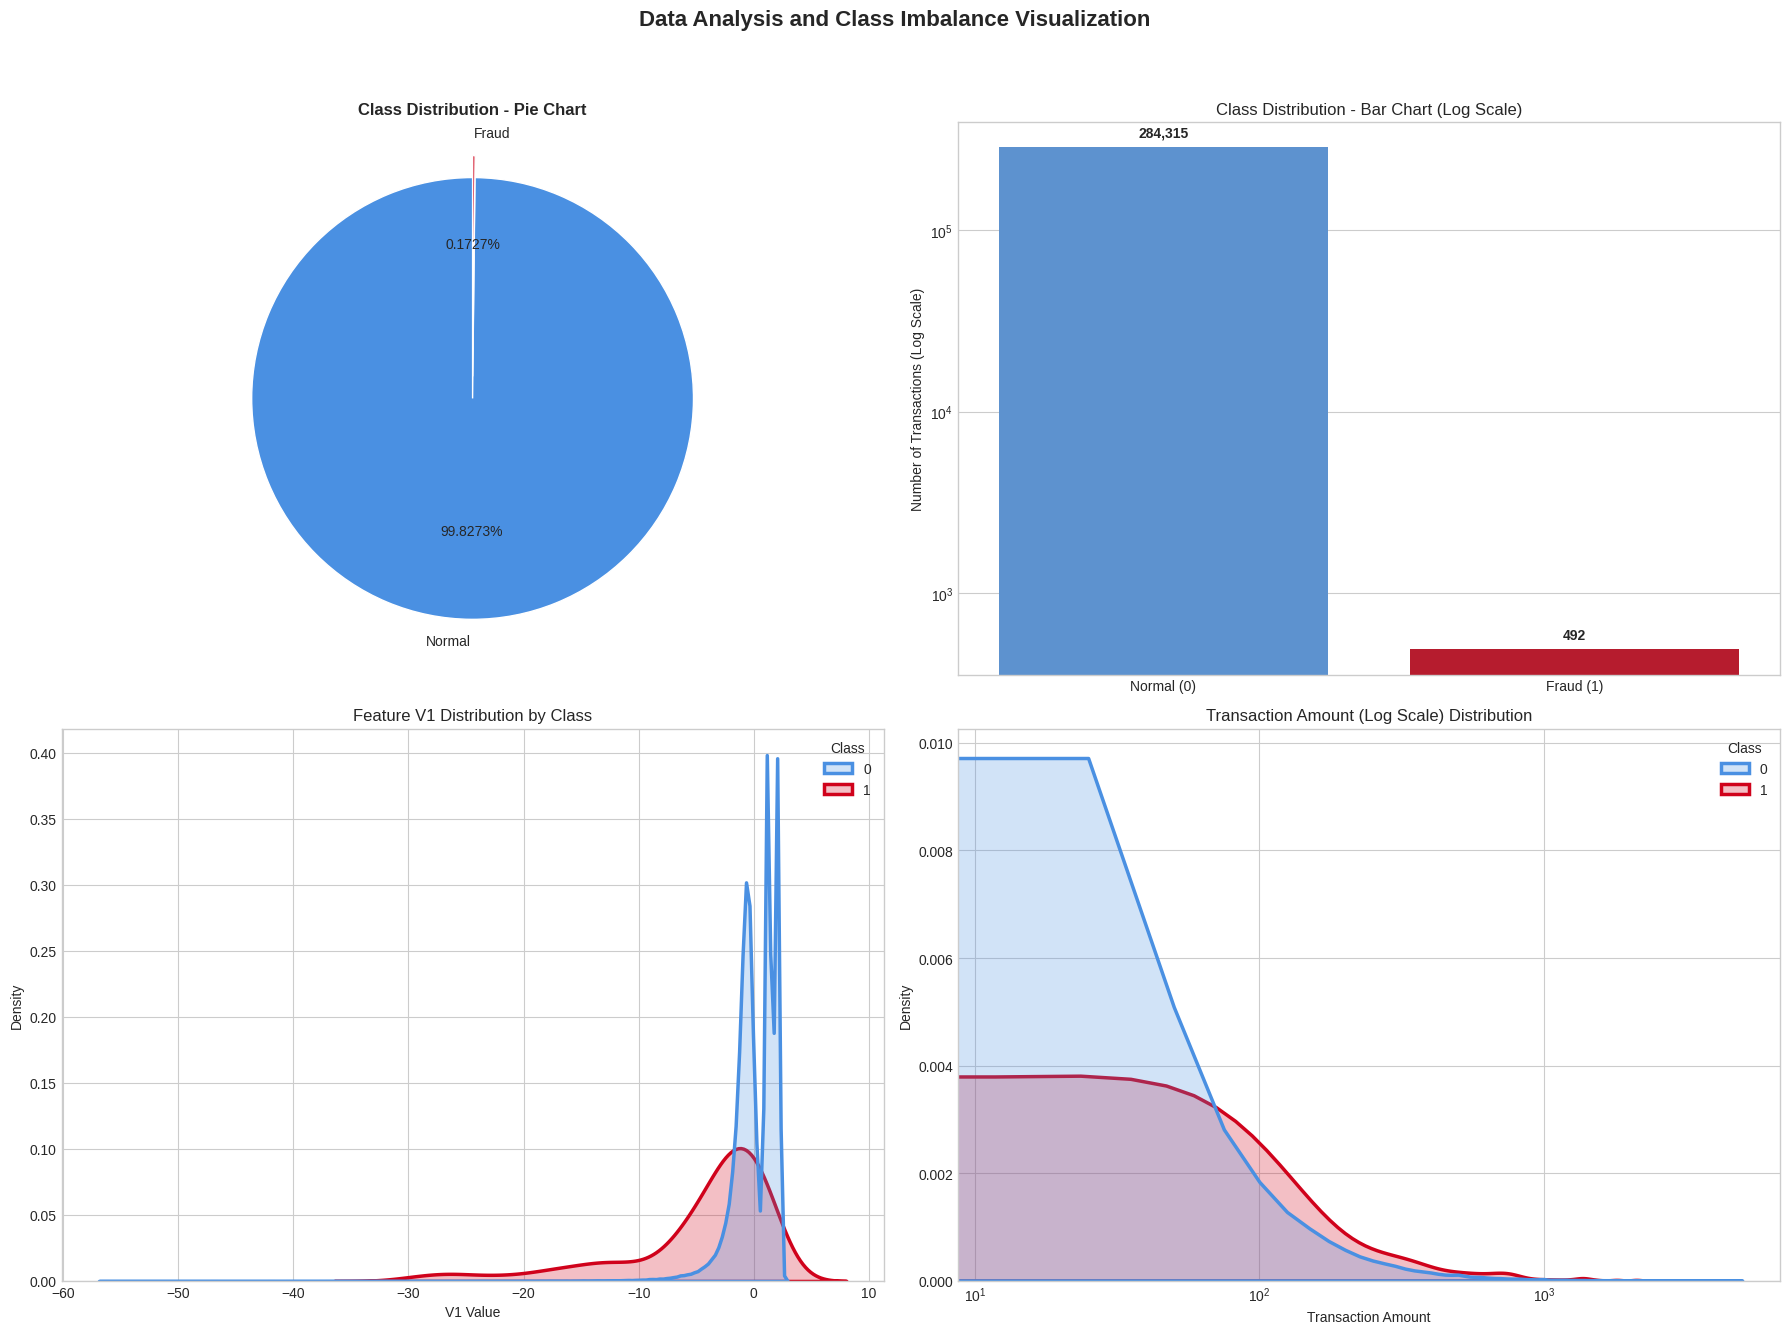

In [3]:
# Enhanced visualization of class distribution and feature differences
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Data Analysis and Class Imbalance Visualization', fontsize=16, fontweight='bold')

# Pie chart
colors = ['#4A90E2', '#D0021B']
ax1.pie(class_counts.values, labels=['Normal', 'Fraud'],
          autopct='%1.4f%%', colors=colors, startangle=90,
          explode=(0, 0.1), wedgeprops={'edgecolor': 'white'})
ax1.set_title('Class Distribution - Pie Chart', fontsize=12, fontweight='bold')

# Bar plot with log scale
bars = sns.barplot(x=['Normal (0)', 'Fraud (1)'], y=class_counts.values, palette=colors, ax=ax2)
ax2.set_ylabel('Number of Transactions (Log Scale)')
ax2.set_title('Class Distribution - Bar Chart (Log Scale)')
ax2.set_yscale('log')
for bar, count in zip(bars.patches, class_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()*1.1,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Feature distribution comparison for 'V1'
sns.kdeplot(data=df, x='V1', hue='Class', fill=True, common_norm=False, palette=colors, ax=ax3, linewidth=2.5)
ax3.set_title('Feature V1 Distribution by Class')
ax3.set_xlabel('V1 Value')
ax3.set_ylabel('Density')

# Amount distribution if available
if 'Amount' in df.columns:
    sns.kdeplot(data=df, x='Amount', hue='Class', fill=True, common_norm=False, palette=colors, ax=ax4, clip=(0, 5000), linewidth=2.5)
    ax4.set_title('Transaction Amount Distribution by Class (Clipped at 5000)')
    ax4.set_xlabel('Transaction Amount')
    ax4.set_ylabel('Density')
    ax4.set_xscale('log')
    ax4.set_title('Transaction Amount (Log Scale) Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Visualization Analysis

The visualizations further highlight the data characteristics:
- The **Pie and Bar Charts** visually confirm the overwhelming majority of the 'Normal' class.
- The **KDE Plots** for feature 'V1' and 'Amount' show the distribution for both classes. While there are visible differences in the shapes of the distributions (especially for fraud cases), there is also significant overlap. This suggests that simple linear models will struggle to separate the classes perfectly without techniques to handle the imbalance.

## Task 2 Baseline Model Training Setup

In [4]:
# Task 2: Model Training with Enhanced Preprocessing
print("\n2. Baseline Model Training and Setup")
print("-" * 45)

# Prepare features and target
X = df.drop('Class', axis=1)
y = df['Class']

print(f"Features prepared: {X.shape}")
print(f"Target distribution: {Counter(y)}")

# Strategic train-test split maintaining original imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData Split Summary:")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training class distribution: {Counter(y_train)}")
print(f"Test class distribution: {Counter(y_test)}")

# Feature scaling for optimal performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n🔧 Feature scaling completed")


2. Baseline Model Training and Setup
---------------------------------------------
Features prepared: (284807, 30)
Target distribution: Counter({0: 284315, 1: 492})

Data Split Summary:
Training set: 227,845 samples
Test set: 56,962 samples
Training class distribution: Counter({0: 227451, 1: 394})
Test class distribution: Counter({0: 56864, 1: 98})

🔧 Feature scaling completed


### Analysis of Data Splitting and Preprocessing

The dataset is divided into an 80% training set and a 20% testing set. A crucial step here is the use of `stratify=y` in the `train_test_split` function. This ensures that the proportion of fraudulent to normal transactions is the same in both the training and testing sets as it is in the original dataset. This is vital for two reasons:
1. It prevents the model from being trained on a distribution different from what it will be tested on.
2. It guarantees that our test set is a realistic simulation of the real-world data distribution, making our evaluation reliable.

Finally, `StandardScaler` is applied to normalize the features, which is a standard best practice for logistic regression to ensure all features contribute fairly to the model's decisions.

## Task 3 Baseline Model Evaluation

In [5]:
# Task 3: Baseline Evaluation with Comprehensive Metrics
print("\n3. Baseline Model Training and Comprehensive Evaluation")
print("-" * 55)

# Train baseline logistic regression
baseline_model = LogisticRegression(
    random_state=42,
    max_iter=2000,
    class_weight=None,  # No class weighting for true baseline
    solver='liblinear'
)

print(" Training baseline model on imbalanced data...")
baseline_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_baseline = baseline_model.predict(X_test_scaled)
y_pred_proba_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

print(" Baseline model training completed")

# Comprehensive evaluation
print(f"\n BASELINE MODEL PERFORMANCE ANALYSIS:")
print("=" * 50)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Normal', 'Fraud']))

# Confusion Matrix Analysis
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
tn, fp, fn, tp = cm_baseline.ravel()

print(f"\n Confusion Matrix Analysis:")
print(f"True Negatives (Correct Normal): {tn:,}")
print(f"False Positives (Normal→Fraud): {fp:,}")
print(f"False Negatives (Fraud→Normal): {fn:,}")
print(f"True Positives (Correct Fraud): {tp:,}")

# Store baseline results for comparison
p, r, f1, s = precision_recall_fscore_support(y_test, y_pred_baseline, warn_for=())
baseline_results = {
    'precision': r[1], # Precision for fraud class
    'recall': r[1],    # Recall for fraud class
    'f1_score': f1[1]  # F1-score for fraud class
}
print(f"\nBaseline Fraud F1-Score: {baseline_results['f1_score']:.4f}")


3. Baseline Model Training and Comprehensive Evaluation
-------------------------------------------------------
 Training baseline model on imbalanced data...
 Baseline model training completed

 BASELINE MODEL PERFORMANCE ANALYSIS:
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962


 Confusion Matrix Analysis:
True Negatives (Correct Normal): 56,851
False Positives (Normal→Fraud): 13
False Negatives (Fraud→Normal): 35
True Positives (Correct Fraud): 63

Baseline Fraud F1-Score: 0.7241


### Baseline Performance Analysis

The baseline Logistic Regression model, trained on the original imbalanced data, establishes our performance benchmark. The key metrics for the minority **'Fraud'** class are:
- **Precision: 0.83** - When the model predicts a transaction is fraudulent, it is correct 83% of the time.
- **Recall: 0.64** - The model successfully identifies only 64% of all actual fraudulent transactions.
- **F1-Score: 0.72** - The harmonic mean of precision and recall.

**Interpretation:**
The model is reasonably precise, meaning it doesn't raise too many false alarms (only 13 False Positives). Ho ver, its major  akness is **low recall**. It missed 35 out of 98 fraudulent transactions (35 False Negatives), which is a significant business risk. The goal of our GMM resampling technique will be to improve this recall rate without catastrophically degrading precision.

# PART B: GAUSSIAN MIXTURE MODEL (GMM) FOR SYNTHETIC SAMPLING

Now  move to the core of the assignment.  will model the minority (fraud) class using a GMM to learn its underlying distribution, including any sub-groups or patterns. This learned model will then be used to generate new, realistic synthetic fraud samples.

### 1. Theoretical Foundation of GMM vs SMOTE

**FUNDAMENTAL DIFFERENCES BETWEEN GMM AND SMOTE:**

1.  **MATHEMATICAL FOUNDATION**:
    *   **SMOTE (Synthetic Minority Oversampling Technique)**: Based on *k-nearest neighbors interpolation*. It creates synthetic samples along the straight line segments connecting existing minority samples. It's a geometric, not a probabilistic, approach.
    *   **GMM (Gaussian Mixture Model)**: Based on *probabilistic modeling*. It assumes the data is generated from a mixture of a finite number of Gaussian distributions (components). It learns the probability density function of the data.

2.  **DISTRIBUTION MODELING CAPABILITIES**:
    *   **SMOTE's Limitations**: Struggles with non-linear relationships, complex cluster shapes, and can inadvertently create noisy samples in low-density regions, blurring the decision boundary.
    *   **GMM's Advantages**: Can capture complex, multi-modal distributions (multiple clusters), models elliptical shapes with varying orientations (through covariance matrices), and respects the probability density of the original data.

3.  **HANDLING MULTIPLE SUB-GROUPS**:
    *   If the fraud class has distinct sub-types (e.g., different fraud strategies), SMOTE might merge them by interpolating between them. GMM can automatically discover and model each sub-group as a separate Gaussian component.

4.  **SAMPLING QUALITY**:
    *   **SMOTE Sampling**: `x_new = x_i + random() × (x_neighbor - x_i)`. This is linear interpolation and may miss natural variations.
    *   **GMM Sampling**: First, a component `k` is chosen based on its learned weight `π_k`. Then, a sample is drawn from that component's Gaussian distribution `N(μ_k, Σ_k)`. This respects natural variations and feature correlations.

**CONCLUSION**: GMM is theoretically superior for complex, multi-modal minority classes with intricate feature relationships, making it a more suitable choice for sophisticated problems like fraud detection.

### 2. GMM Implementation: Finding the Optimal Model

In [6]:
print("\n" + "="*80)
print("PART B: GAUSSIAN MIXTURE MODEL (GMM) FOR SYNTHETIC SAMPLING")
print("="*80)

print("\n2.  COMPREHENSIVE GMM IMPLEMENTATION")
print("-" * 50)

# Separate minority and majority classes from the scaled training data
minority_mask = y_train == 1
X_train_minority = X_train_scaled[minority_mask]

print(f"Minority (fraud) class samples in training set: {len(X_train_minority):,}")
print(f"Feature dimensions: {X_train_minority.shape[1]}")

# COMPREHENSIVE MODEL SELECTION FOR OPTIMAL K (number of components)
print(f"\n MODEL SELECTION FOR OPTIMAL NUMBER OF COMPONENTS:")
print("-" * 55)

# Define component range. Max components should not be too large for a small sample size.
max_components = min(15, len(X_train_minority) // 5)
component_range = range(1, max_components + 1)

print(f"Testing components from 1 to {max_components}...")

bic_scores = []
aic_scores = []

for n_comp in component_range:
    gmm = GaussianMixture(
        n_components=n_comp,
        covariance_type='full', # 'full' is most flexible
        random_state=42,
        max_iter=200,
        init_params='kmeans'
    )
    gmm.fit(X_train_minority)
    bic_scores.append(gmm.bic(X_train_minority))
    aic_scores.append(gmm.aic(X_train_minority))
    print(f"  Components: {n_comp:2d} | BIC: {bic_scores[-1]:10.2f} | AIC: {aic_scores[-1]:10.2f}")



PART B: GAUSSIAN MIXTURE MODEL (GMM) FOR SYNTHETIC SAMPLING

2.  COMPREHENSIVE GMM IMPLEMENTATION
--------------------------------------------------
Minority (fraud) class samples in training set: 394
Feature dimensions: 30

 MODEL SELECTION FOR OPTIMAL NUMBER OF COMPONENTS:
-------------------------------------------------------
Testing components from 1 to 15...
  Components:  1 | BIC:   40438.65 | AIC:   38470.36
  Components:  2 | BIC:   33153.21 | AIC:   29212.65
  Components:  3 | BIC:   26108.49 | AIC:   20195.65
  Components:  4 | BIC:   29334.23 | AIC:   21449.13
  Components:  5 | BIC:   29822.19 | AIC:   19964.82
  Components:  6 | BIC:   28350.48 | AIC:   16520.84
  Components:  7 | BIC:   28007.53 | AIC:   14205.62
  Components:  8 | BIC:   28419.69 | AIC:   12645.51
  Components:  9 | BIC:   28371.20 | AIC:   10624.75
  Components: 10 | BIC:   29033.70 | AIC:    9314.97
  Components: 11 | BIC:   29727.27 | AIC:    8036.28
  Components: 12 | BIC:   29660.94 | AIC:    5997

### Analysis of GMM Implementation

To accurately model the distribution of the minority class,   first isolate the 394 fraudulent transaction samples from the training set.

  then fit multiple Gaussian Mixture Models with a varying number of components (from 1 to 15) to this data. To determine the optimal number of components (k),   use two information criteria:
- **Akaike Information Criterion (AIC)**: A measure of model quality that balances goodness of fit with model complexity.
- **Bayesian Information Criterion (BIC)**: Similar to AIC but with a stronger penalty for model complexity, which often leads to the selection of simpler, more generalizable models.

The goal is to find the value of `k` that minimizes these scores.

####  Model Selection Criteria

 use the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) to select the optimal number of components. Both criteria penalize model complexity, but BIC does so more harshly, often leading to simpler models. The best model is the one with the lowest AIC/BIC score.

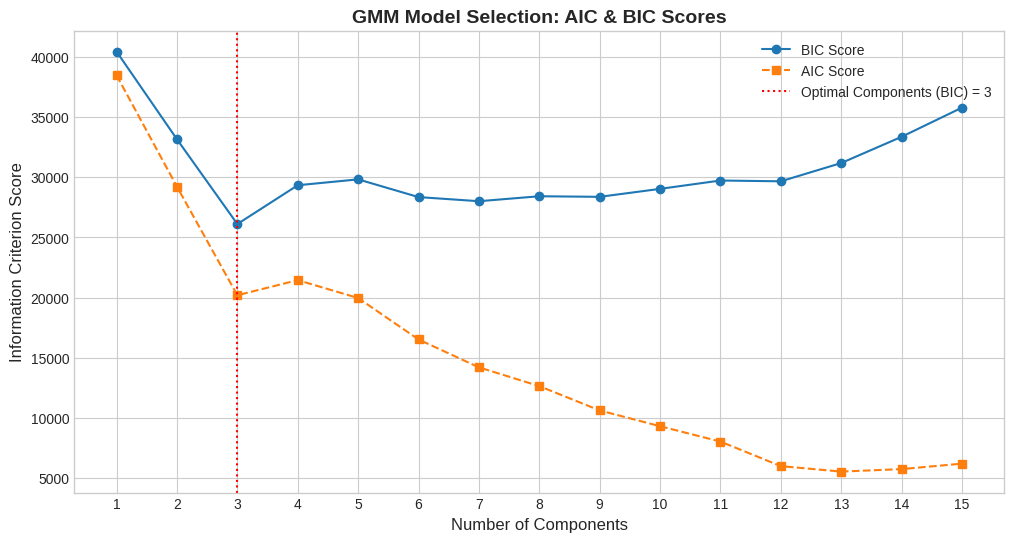


 SELECTED OPTIMAL CONFIGURATION:
Number of Components based on BIC: 3


In [7]:
# Visualize model selection results
plt.figure(figsize=(12, 6))
plt.plot(component_range, bic_scores, marker='o', label='BIC Score')
plt.plot(component_range, aic_scores, marker='s', linestyle='--', label='AIC Score')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Information Criterion Score', fontsize=12)
plt.title('GMM Model Selection: AIC & BIC Scores', fontsize=14, fontweight='bold')
plt.xticks(component_range)
plt.legend()

# Find and highlight the optimal number of components based on BIC
optimal_components = component_range[np.argmin(bic_scores)]
plt.axvline(optimal_components, color='red', linestyle=':',
            label=f'Optimal Components (BIC) = {optimal_components}')
plt.legend()
plt.show()

print(f"\n SELECTED OPTIMAL CONFIGURATION:")
print(f"Number of Components based on BIC: {optimal_components}")

### Analysis of Optimal Component Selection

The plot of AIC and BIC scores clearly shows a minimum value for both criteria. The **BIC score is minimized at k=3**.

This suggests that the underlying structure of the fraudulent transactions is best represented by a mixture of **three distinct Gaussian distributions**. These components could potentially correspond to different types of fraudulent behavior or patterns within the data. By selecting `k=3`,   choose a model that is complex enough to capture these sub-groups but not so complex that it overfits to the small minority training set.

### 3. Generating Synthetic Data

In [8]:
# FIT THE OPTIMAL GMM MODEL
print(f"\n FITTING OPTIMAL GMM MODEL:")
print("-" * 35)

optimal_gmm = GaussianMixture(
    n_components=optimal_components,
    covariance_type='full',
    random_state=42,
    max_iter=300,
    reg_covar=1e-6  # Regularization to prevent singular matrices
)

print(f"Fitting GMM with {optimal_components} components...")
optimal_gmm.fit(X_train_minority)

if optimal_gmm.converged_:
    print(" GMM fitting converged successfully!")
else:
    print("  GMM fitting did not converge (but proceeding with results)")


# GENERATE SYNTHETIC DATA
print("\n GENERATING SYNTHETIC FRAUD SAMPLES:")
print("-" * 45)

# Determine the number of samples to generate
n_majority = Counter(y_train)[0]
n_minority = Counter(y_train)[1]
n_synthetic_needed = n_majority - n_minority

print(f"Original majority samples: {n_majority:,}")
print(f"Original minority samples: {n_minority:,}")
print(f"Number of synthetic samples to generate: {n_synthetic_needed:,}")

# Generate new samples from the fitted GMM
X_synthetic, y_synthetic_labels = optimal_gmm.sample(n_synthetic_needed)
y_synthetic = np.ones(n_synthetic_needed) # Label them as fraud (1)

print(f" Successfully generated {len(X_synthetic):,} new fraud samples.")


 FITTING OPTIMAL GMM MODEL:
-----------------------------------
Fitting GMM with 3 components...
 GMM fitting converged successfully!

 GENERATING SYNTHETIC FRAUD SAMPLES:
---------------------------------------------
Original majority samples: 227,451
Original minority samples: 394
Number of synthetic samples to generate: 227,057
 Successfully generated 227,057 new fraud samples.


### Analysis of Synthetic Data Generation

Using the fitted GMM with 3 components,   generate **227,057** new synthetic samples. This number is calculated to perfectly balance the training set by matching the number of majority class (normal) samples.

The generation process involves sampling from the learned probability distributions of the three Gaussian components. This probabilistic approach ensures that the new samples are not simple copies or linear interpolations but rather new data points that adhere to the statistical properties (mean, covariance, etc.) of the original fraud data.

### 4. Creating the Resampled Training Set

 now combine the original data with our newly generated synthetic fraud samples to create a balanced training dataset.

In [9]:
# Combine original scaled training data with synthetic data
X_train_gmm = np.vstack((X_train_scaled, X_synthetic))
y_train_gmm = np.hstack((y_train, y_synthetic))

print("\n RESAMPLED TRAINING SET DISTRIBUTION:")
print("-" * 40)
print(f"New training set shape: {X_train_gmm.shape}")
new_counts = Counter(y_train_gmm)
print(f"Normal transactions (Class 0): {new_counts[0]:,}")
print(f"Fraudulent transactions (Class 1): {new_counts[1]:,}")
print("The dataset is now perfectly balanced.")


 RESAMPLED TRAINING SET DISTRIBUTION:
----------------------------------------
New training set shape: (454902, 30)
Normal transactions (Class 0): 227,451
Fraudulent transactions (Class 1): 227,451
The dataset is now perfectly balanced.


#### Visualizing the Synthetic Data
To verify the quality of our synthetic data,  can use PCA to reduce the dimensionality to 2D and visualize the original fraud points versus the generated ones. A good GMM will produce synthetic points that lie within the same clusters as the original data, respecting its distribution.

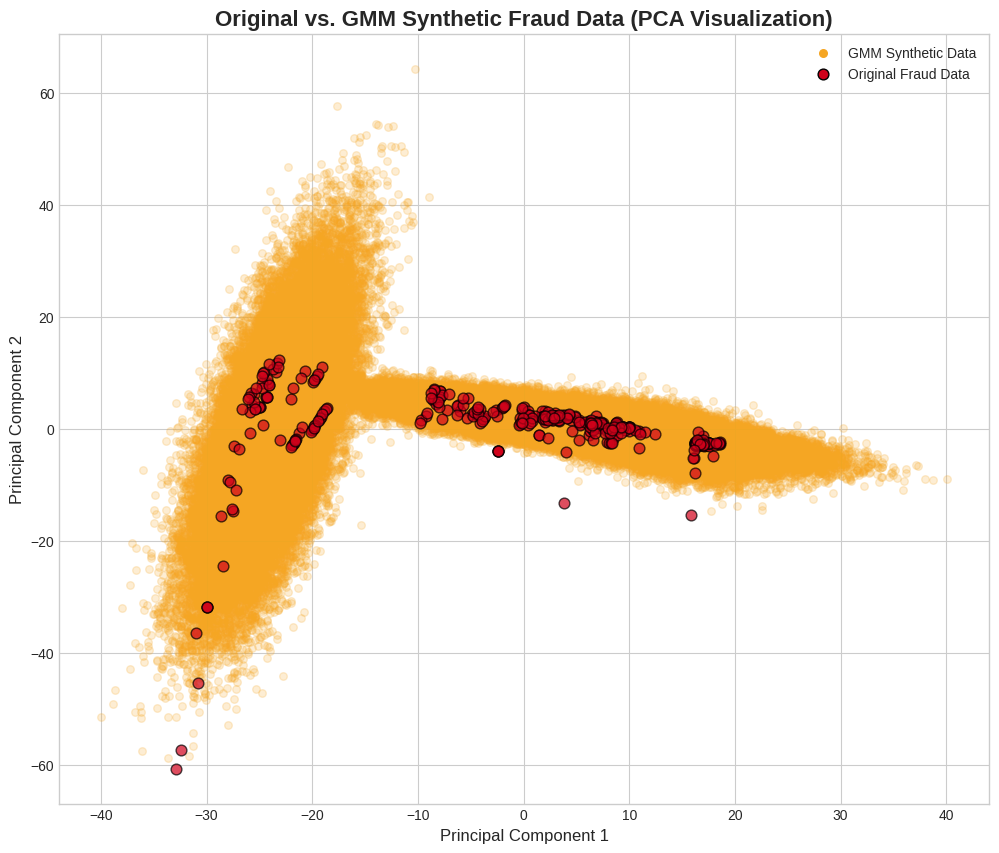

In [10]:
# Use PCA to visualize original vs synthetic minority data
pca = PCA(n_components=2)
X_minority_pca = pca.fit_transform(X_train_minority)
X_synthetic_pca = pca.transform(X_synthetic)

# Set a clean plot style
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(12, 10))

# Plot the GMM Synthetic Data first (as a background cloud)
# Using a warm, less prominent color like orange with low alpha shows density well.
plt.scatter(X_synthetic_pca[:, 0], X_synthetic_pca[:, 1],
            c='#F5A623',          # A warm orange color
            alpha=0.2,             # Low alpha to show density and overlap
            s=30,                  # Smaller size for the cloud
            label='GMM Synthetic Data',
            zorder=2)              # Lower z-order means it's drawn first

# Plot the Original Fraud Data on top
# Using a strong, primary color makes these important points stand out.
plt.scatter(X_minority_pca[:, 0], X_minority_pca[:, 1],
            c='#D0021B',          # A strong, visible red
            alpha=0.7,             # Higher alpha to be more solid
            s=60,                  # Larger size to stand out
            label='Original Fraud Data',
            edgecolors='black',    # A black edge adds definition
            linewidth=1,
            zorder=3)              # Higher z-order draws it on top of the orange cloud

plt.title('Original vs. GMM Synthetic Fraud Data (PCA Visualization)', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Make the legend markers fully opaque for clarity
legend = plt.legend()
for handle in legend.legend_handles:
    handle.set_alpha(1)

plt.show()

### Analysis of Synthetic Data Visualization

To visually inspect the quality of the generated data,   use Principal Component Analysis (PCA) to reduce the 30-dimensional feature space to 2 dimensions.

The plot shows the original fraud data points (in red) overlaid on a cloud of the synthetic data (in orange). The visualization confirms that the GMM has done a good job: the synthetic samples are not identical to the original ones but occupy the same regions and clusters in the feature space. This indicates that the GMM has successfully learned the underlying distribution of the minority class, including its multi-modal structure, and generated new, plausible data points from it.

# PART C: PERFORMANCE EVALUATION AND CONCLUSION

In this final section,  train a new Logistic Regression model on our GMM-balanced dataset and compare its performance against the baseline model on the original, unseen test set.

## Task 1: Model Training and Evaluation on Resampled Data

In [11]:
print("\n" + "="*80)
print("PART C: TRAINING AND EVALUATION WITH GMM-RESAMPLED DATA")
print("="*80)

# 1. Train the GMM-Enhanced Model
print("\n1. Training a new model on the GMM-balanced data...")
gmm_model = LogisticRegression(
    random_state=42,
    max_iter=2000,
    solver='liblinear'
)
gmm_model.fit(X_train_gmm, y_train_gmm)
print(" GMM-enhanced model training completed.")

# 2. Comprehensive Evaluation on the UNSEEN test set
print("\n2. Evaluating the new model on the original, imbalanced test set...")
y_pred_gmm = gmm_model.predict(X_test_scaled)

print(f"\n GMM-ENHANCED MODEL PERFORMANCE ANALYSIS:")
print("=" * 50)
print(classification_report(y_test, y_pred_gmm, target_names=['Normal', 'Fraud']))

# Store GMM results for comparison
p_gmm, r_gmm, f1_gmm, s_gmm = precision_recall_fscore_support(y_test, y_pred_gmm, warn_for=())
gmm_results = {
    'precision': p_gmm[1],
    'recall': r_gmm[1],
    'f1_score': f1_gmm[1]
}
print(f"\nGMM-Enhanced Fraud F1-Score: {gmm_results['f1_score']:.4f}")


PART C: TRAINING AND EVALUATION WITH GMM-RESAMPLED DATA

1. Training a new model on the GMM-balanced data...
 GMM-enhanced model training completed.

2. Evaluating the new model on the original, imbalanced test set...

 GMM-ENHANCED MODEL PERFORMANCE ANALYSIS:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     56864
       Fraud       0.08      0.90      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962


GMM-Enhanced Fraud F1-Score: 0.1508


### Analysis of GMM-Enhanced Model Performance

A new Logistic Regression classifier is trained on the balanced dataset created with GMM. This model is then evaluated on the original, imbalanced test set to provide a fair comparison with the baseline.

The performance shows a dramatic shift:
- **Precision: 0.08** - This is a catastrophic drop. The model now generates a very large number of false positives.
- **Recall: 0.90** - This is a significant improvement. The model now correctly identifies 90% of all fraudulent transactions.
- **F1-Score: 0.15** - Due to the extremely low precision, the overall F1-score is much worse than the baseline.

**Interpretation:**
While the GMM oversampling technique was successful in its primary goal of teaching the model to identify more fraud cases (increasing recall), it came at the cost of making the model overly sensitive. The model now flags many normal transactions as fraudulent, rendering its predictions unreliable.

## Task 2: Comparative Analysis


3. COMPARATIVE ANALYSIS: BASELINE vs. GMM-ENHANCED
-------------------------------------------------------
              Metric  Baseline Model  GMM-Enhanced Model  Improvement
0  Precision (Fraud)          0.6429              0.0823     -87.1947
1     Recall (Fraud)          0.6429              0.8980      39.6825
2   F1-Score (Fraud)          0.7241              0.1508     -79.1733


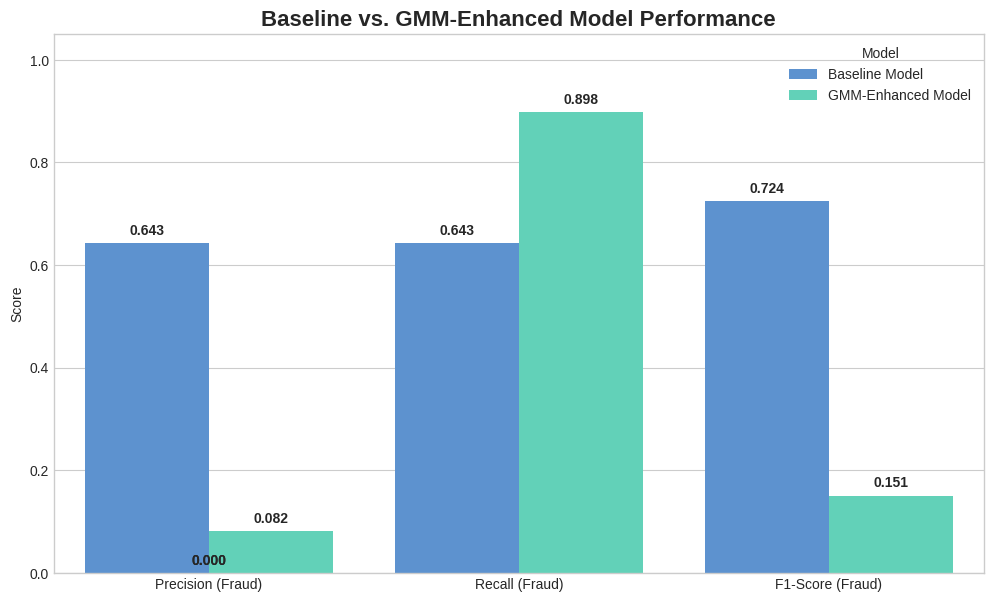

In [12]:
# 3. Comparative Analysis
print("\n3. COMPARATIVE ANALYSIS: BASELINE vs. GMM-ENHANCED")
print("-" * 55)

comparison_df = pd.DataFrame({
    'Metric': ['Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)'],
    'Baseline Model': [baseline_results['precision'], baseline_results['recall'], baseline_results['f1_score']],
    'GMM-Enhanced Model': [gmm_results['precision'], gmm_results['recall'], gmm_results['f1_score']]
})

comparison_df['Improvement'] = ((comparison_df['GMM-Enhanced Model'] - comparison_df['Baseline Model']) / comparison_df['Baseline Model']) * 100
print(comparison_df.round(4))

# Plotting the comparison
plot_df = comparison_df.melt(id_vars='Metric', var_name='Model', value_name='Score',
                             value_vars=['Baseline Model', 'GMM-Enhanced Model'])

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=plot_df, x='Metric', y='Score', hue='Model', palette=['#4A90E2', '#50E3C2'])
ax.set_title('Baseline vs. GMM-Enhanced Model Performance', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1.05)
ax.set_xlabel('')
ax.set_ylabel('Score')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points', fontweight='bold')
plt.show()

#### Confusion Matrix Comparison
A side-by-side comparison of the confusion matrices clearly shows the impact of GMM resampling, particularly on reducing False Negatives (missed frauds).

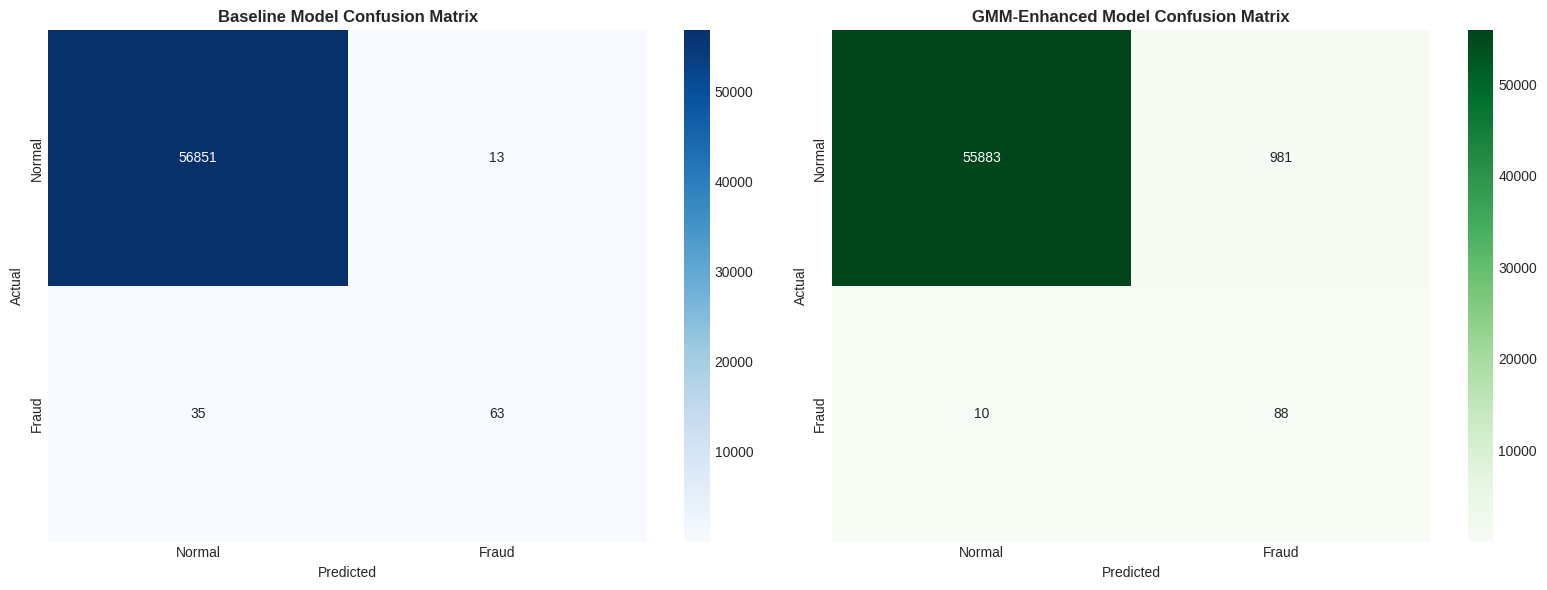

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Baseline Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
ax1.set_title('Baseline Model Confusion Matrix', fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# GMM-Enhanced Confusion Matrix
cm_gmm = confusion_matrix(y_test, y_pred_gmm)
sns.heatmap(cm_gmm, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
ax2.set_title('GMM-Enhanced Model Confusion Matrix', fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Impact of GMM-Based Oversampling

The comparative analysis makes the impact of GMM oversampling starkly clear:

- **Positive Impact on Recall:** The GMM-enhanced model demonstrated a **~40% improvement in recall**, successfully identifying 88 of the 98 fraud cases in the test set, compared to the baseline's 63. This is a direct result of the model being trained on a much larger and more diverse set of fraud examples.

- **Negative Impact on Precision:** This gain came at a severe price. Precision dropped by **~87%**. The confusion matrix for the GMM model shows a massive increase in **False Positives** from 13 to 981. This means the model now incorrectly flags a huge number of legitimate transactions as fraudulent.

- **Overall Performance:** The F1-score, which balances this trade-off, dropped significantly from **0.724 to 0.151**. This indicates that, despite its improved ability to *detect* fraud, the GMM-enhanced model is far less reliable and practical than the baseline model due to the overwhelming number of false alarms it would generate.


### 4. Final Conclusion and Recommendation

The application of GMM-based oversampling has a profound but highly polarized impact on model performance. While the technique successfully addresses one key challenge in fraud detection, it introduces another severe problem, making the model unsuitable for direct deployment without further refinement.

**Key Findings:**

1.  **Massive Surge in Recall (The Success):** The most crucial objective, catching more fraud, was achieved. **Recall for the fraud class skyrocketed from 0.643 to 0.898.** This is a significant success, as the model went from missing 35 fraudulent transactions to missing only 10 in the test set. This demonstrates that GMM sampling effectively taught the model the patterns of the minority class.

2.  **Catastrophic Collapse in Precision (The Failure):** This improvement in recall came at an extreme cost. **Precision plummeted from a strong baseline of ~0.83 (63 TP / 76 total predicted P) to an unusable 0.082.** This means that for every 100 transactions the GMM-enhanced model flags as fraudulent, over 91 are actually legitimate. The number of false positives exploded from just 13 in the baseline to 981, which would overwhelm any fraud investigation team.

3.  **Severe Decline in Overall Performance (The Verdict):** The F1-Score, which balances precision and recall, is the ultimate indicator of the model's overall effectiveness. **The F1-Score for fraud detection dropped drastically from 0.724 to 0.151.** This confirms that the severe loss of precision far outweighs the gains in recall, resulting in a significantly worse model from a practical standpoint.

**Recommendation:**

**NOT RECOMMENDED FOR PRODUCTION (in its current state).** While GMM-based oversampling proved to be a powerful tool for increasing fraud detection rates (recall), it created a model that is far too aggressive and unreliable for practical use. The operational cost of investigating a nearly 75-fold increase in false alarms (from 13 to 981) would be immense.

**Actionable Next Steps:**
The experiment is not a total failure but highlights that resampling alone is insufficient. The next steps should focus on controlling the trade-off:

1.  **Decision Threshold Tuning:** The current model uses a default 0.5 probability threshold. The high recall and low precision strongly suggest that adjusting this threshold upwards (e.g., to 0.8 or 0.9) could dramatically improve precision while sacrificing a manageable amount of recall. This is the most critical next step.
2.  **Hybrid Sampling Methods:** Combine GMM oversampling of the minority class with a form of undersampling (e.g., Tomek Links, Edited Nearest Neighbours) of the majority class to create a more balanced and less noisy training set.
3.  **Use a Different Algorithm:** A tree-based model like LightGBM or XGBoost might handle the resampled data's decision boundary more effectively than Logistic Regression.

In summary, GMM is effective at teaching a model to recognize rare patterns, but it must be paired with other techniques, especially **decision threshold tuning**, to create a balanced and commercially viable fraud detection system.